In [ ]:
import pyomo.environ as pyo
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import cycle
import pandas as pd


In [ ]:
# FILE = 'test1'
# ACCURATE = False
# FILE = 'shuffled_ordered_data/R211_shuffled_ordered'
# FILE = 'shuffled_data/RC208_shuffled'
# FILE = 'test_data/test4'
# FILE = 'test_data/R211_test'
FILE = 'experiment2_data/C201_test'
FILE_NAME = "C:/Users/caleb/Desktop/Study/FYP/Data/"+FILE+".csv"
data = pd.read_csv(FILE_NAME)
data.columns = data.columns.astype(str)

In [5]:
PLANNING_TIME = 0
CUSTOMERS_LIST = []
data = data.loc[(data['DUE DATE'] >= PLANNING_TIME) | (data['CUST NO.'].isin(CUSTOMERS_LIST))]
data.shape

(7, 12)

In [ ]:
N = 100
CAPACITY = 100
N_VEHICLES = 8
R = 4 #number of trips. set to a fiarly large number
DEMAND_TYPES = 5
VEHICLE_COMPARMENTS = 5

vehicle_capacities = np.array([[CAPACITY]*DEMAND_TYPES]*N_VEHICLES)
df = data[:N+1]
cust_no = np.array(df.loc[:,'CUST NO.'])
demands = np.array(df.loc[:,'DEMAND'])
service_time = np.array(df.loc[:,'SERVICE TIME'])#demands #np.zeros(len(demands)) #demands 
demands_zeros = np.zeros((len(demands), DEMAND_TYPES-1))
demands = np.hstack((demands.reshape(N+1,1),demands_zeros))
coordinates = np.array(df.loc[:,['XCOORD','YCOORD']])
start_time_windows = np.array(df.loc[:,'READY TIME'])
end_time_windows = np.array(df.loc[:,'DUE DATE']) #+ service_time

demands_index = [i for i in range(1,N+1)]

START_TIME = start_time_windows[0]
# START_TIME = 100
END_TIME = end_time_windows[0] #+ service_time[1]

print(START_TIME)
print(END_TIME)

0
1000


In [7]:
coordinates

array([[28. , 28. ],
       [35. , 30. ],
       [32.5, 34.3],
       [27.5, 34.3],
       [25. , 30. ],
       [27.5, 25.7],
       [32.5, 25.7]])

In [8]:
end_time_windows

array([1000, 1000, 1000, 1000, 1000, 1000, 1000], dtype=int64)

In [9]:
def crazyshuffle(arr,seed):
    rng = np.random.default_rng(seed=seed)
    x, y = arr.shape
    rows = np.indices((x,y))[0]
    cols = [rng.permutation(y) for _ in range(x)]
    return arr[rows, cols]

In [10]:
demands_empty = np.zeros(demands.shape)
count = 0
for i , demand in enumerate(demands):
    for j , d in enumerate(demand):
        if d != 0:
            demands_empty[i,count] = demands[i,j]
            if count < DEMAND_TYPES-1:
                count += 1
            else:
                count = 0
demands_empty

array([[ 0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [10.,  0.,  0.,  0.,  0.]])

In [11]:
SEED = 69
#service_time = demands #np.array(df.loc[:,'SERVICE TIME'])
demands_shuffled = crazyshuffle(demands,SEED)#demands#demands_empty#crazyshuffle(demands,SEED)
demands_shuffled

array([[ 0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0., 10.,  0.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.]])

In [12]:
demands_shuffled = np.array(df.iloc[:,4:9])
demands_shuffled

array([[ 0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [10,  0,  0,  0,  0],
       [10,  0,  0,  0,  0]], dtype=int64)

In [13]:
TOTAL_GOODS = demands_shuffled.sum()
TOTAL_GOODS

60

In [14]:
print('Max possible score:', np.abs(demands_shuffled).sum())
#print('Max goods:', np.abs(demands).sum()/2)
print ('Veh max Capacity:', vehicle_capacities.sum())

Max possible score: 60
Veh max Capacity: 300


In [15]:
distances = squareform(pdist(coordinates, metric="euclidean"))
def trunc(values, decs=1):
    return np.trunc(values*10**decs)/(10**decs)
distances = trunc(distances)
# distances = np.round(distances, decimals=2)

#travel_time = distances/5
travel_time = distances
# travel_time

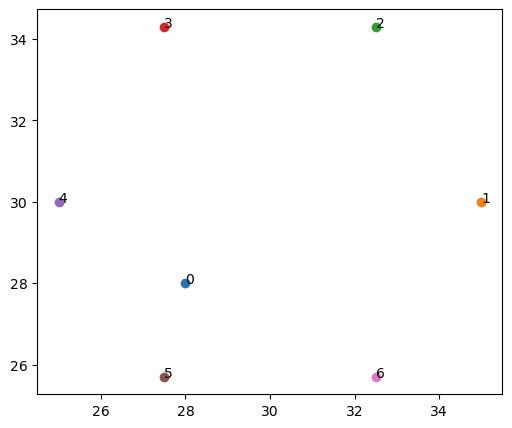

In [18]:
# Choosing colors
cmap = mpl.colormaps["Dark2"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

for i, coord in enumerate(coordinates):
    x = coord[0]
    y= coord[1]
    ax.scatter(x,y)
    ax.annotate(i, (x,y))

In [19]:
model = pyo.ConcreteModel()

## Sets

In [ ]:
model.D = pyo.Set(initialize=demands_index) #set of vessels
model.N = pyo.Set(initialize=range(len(demands))) # set of vessels+depot
model.N1 = pyo.Set(initialize=range(len(demands)+1)) # set of vessels+depot+end
model.A = pyo.Set(initialize=[(i, j) for i in model.N for j in model.N if i != j]) #set of arcs
model.K = pyo.Set(initialize=range(N_VEHICLES)) #set of vehicles
model.R  = pyo.Set(initialize=range(R)) # set of trips
model.F = pyo.Set(initialize = range(DEMAND_TYPES)) #set of demand types

## Parameters

In [21]:
zeta = 0.01 # travel cost per distance factor
price = [1]*DEMAND_TYPES

In [ ]:
model.q = pyo.Param(model.K, model.F, initialize={(i,f): vehicle_capacities[i,f] for i in model.K for f in model.F}) #capacity of vehicles
model.c = pyo.Param(model.A, initialize={(i, j): zeta*distances[i, j] for (i, j) in model.A}) #cost of travel per arc
model.n = pyo.Param(model.N, model.F, initialize={(i,f): demands_shuffled[i,f] for i in model.N for f in model.F}) #loading of all nodes
model.r = pyo.Param(model.N, model.F, initialize={(i,f): price[f]*demands_shuffled[i,f] for i in model.N for f in model.F}) #revenue of all nodes
model.s = pyo.Param(model.N, initialize=service_time) #service time per node
model.t = pyo.Param(model.N, model.N, initialize={(i, j): travel_time[i, j] for i in model.N for j in model.N}) #travel time per arc)
model.a = pyo.Param(model.N, initialize=start_time_windows) #start time windows per node
model.b = pyo.Param(model.N, initialize=end_time_windows) #end time windows per node

## Variables

In [23]:
new_start_time_windows = np.append(start_time_windows, START_TIME)
new_start_time_windows = [[new_start_time_windows]*R]*N_VEHICLES

new_end_time_windows = np.append(end_time_windows, END_TIME)
new_end_time_windows = [[new_end_time_windows]*R]*N_VEHICLES

In [24]:
def time_windows(model, i,k,r):
    return (new_start_time_windows[k][r][i], new_end_time_windows[k][r][i])

In [ ]:
model.X = pyo.Var(model.A, model.K, model.R, within=pyo.Binary) # decision to move along arc ij by vehicle K on trip R
model.Y = pyo.Var(model.N, model.K, model.R, within=pyo.Binary) # decision of if node N is visited by vehicle K on trip R
model.T = pyo.Var(model.N1, model.K, model.R, within=pyo.NonNegativeReals, bounds= time_windows) # visit time at node N by vehicle K on trip R
model.S = pyo.Var(model.K, model.R, within=pyo.NonNegativeReals, bounds= (0,CAPACITY*DEMAND_TYPES)) #serivce time at the depot for the start of each trip
model.L = pyo.Var([0,N+1], model.K, model.R, model.F, within=pyo.NonNegativeReals, bounds= (0,CAPACITY)) # fuel load on vehicle K on trip R for fuel type F
model.U = pyo.Var(model.N, model.K, model.R, model.F, within=pyo.NonNegativeReals, bounds= (0,CAPACITY))

## Constraints

In [ ]:
M = np.zeros((N+1,N+1))
beta = 0.2 # rate of fuel transfer at the depot
for i in model.N:
    for j in model.N:
         M[i,j] = model.b[i] + model.s[i] + model.t[i,j] - model.a[j]
      #    M[i,j] =  model.b[i] + model.s[i] + travel_time[i,j] 
for j in model.N:
      # M[0,j] = model.b[0] + CAPACITY*DEMAND_TYPES*beta + model.t[0,j] - model.a[j]
      M[0,j] = model.b[0] + model.s[1]*N*beta + model.t[0,j] - model.a[j]
      # M[0,j] =  model.b[0] +CAPACITY*DEMAND_TYPES*0.2 + travel_time[0,j]
print(np.max(M))

1020.0


In [ ]:
def visit_once_rule(model,i): #2/13
    return sum(model.Y[i,k,r] for k in model.K for r in model.R) <= 1
model.visit_once_rule = pyo.Constraint(model.D, rule=visit_once_rule)

def arcs_out_rule(model, i, k,r): #3/14 modifyied Arcs out rule
    return sum(model.X[i, j, k,r] for j in model.N if i != j) == model.Y[i,k,r]
model.arcs_out_rule = pyo.Constraint(model.N, model.K, model.R, rule=arcs_out_rule)

def arcs_in_rule(model, i, k,r): #3/14 modifyied Arcs in rule
    return sum(model.X[j, i, k,r] for j in model.N if i != j) == model.Y[i,k,r]
model.arcs_in_rule = pyo.Constraint(model.N, model.K, model.R, rule=arcs_in_rule)

def feasbile_time_along_arc(model,i,j, k,r): #71
    if i == j:
        return pyo.Constraint.Skip
    else:
        # return model.T[i,k,r] + model.s[i] + model.t[i,j] <= model.T[j,k,r] + M*(1-model.X[i,j,k,r])
        return model.T[i,k,r] + model.s[i] + model.t[i,j] <= model.T[j,k,r] + M[i,j]*(1-model.X[i,j,k,r])
model.feasbile_time_along_arc = pyo.Constraint(model.D, model.D, model.K, model.R, rule=feasbile_time_along_arc)

def feasbile_start_time (model,j,k,r): #72 
    # return model.T[0,k,r] + model.S[k,r] + model.t[0,j] <= model.T[j,k,r] + M*(1-model.X[0,j,k,r])
    return model.T[0,k,r] + model.S[k,r] + model.t[0,j] <= model.T[j,k,r] + M[0,j]*(1-model.X[0,j,k,r])
model.feasbile_start_time = pyo.Constraint(model.D, model.K, model.R, rule=feasbile_start_time)

def feasbile_end_time (model,i,k,r): #66
    # return model.T[i,k,r] + model.s[i] + model.t[i,0] <= model.T[N+1,k,r] + M*(1-model.X[i,0,k,r])
    return model.T[i,k,r] + model.s[i] + model.t[i,0] <= model.T[N+1,k,r] + M[i,0]*(1-model.X[i,0,k,r])
model.feasbile_end_time = pyo.Constraint(model.D, model.K, model.R, rule=feasbile_end_time)

def trip_end_before_start (model, k,r): #67
    if r == model.R.last():
        return pyo.Constraint.Skip
    else:
        return model.T[N+1,k,r] <= model.T[0,k,r+1]
model.trip_end_before_start = pyo.Constraint(model.K, model.R, rule=trip_end_before_start)    

def trip_end_after_start (model, k,r): #modified (necessary)
    return model.T[0,k,r] + model.S[k,r] <= model.T[N+1,k,r]
model.trip_end_after_start = pyo.Constraint(model.K, model.R, rule=trip_end_after_start)    


'\ndef trip_start_after_time_window_start (model, i,k,r): #68\n    # return model.a[i] *model.Y[i,k,r] <= model.T[i,k,r]\n    return model.a[i] <= model.T[i,k,r]\nmodel.trip_start_after_time_window_start = pyo.Constraint(model.D, model.K, model.R, rule=trip_start_after_time_window_start)\n\ndef trip_end_before_time_window_end (model, i,k,r): #68 \n    return model.T[i,k,r] <= (model.b[i]) #*model.Y[i,k,r]\n    # return model.T[i,k,r] <= (model.b[i]- model.s[i])*model.Y[i,k,r]  #modified to include service time\nmodel.trip_end_before_time_window_end = pyo.Constraint(model.D, model.K, model.R, rule=trip_end_before_time_window_end)\n\ndef trip_end_before_end_time(model,k,r): # 69\n    return model.T[N+1,k,r] <= END_TIME\nmodel.trip_end_before_end_time = pyo.Constraint(model.K, model.R, rule=trip_end_before_end_time)'

## Service time at depot

In [ ]:
full_capacity = [CAPACITY]*VEHICLE_COMPARMENTS

def service_time_at_depot (model,k,r): #73 modified
    # if r == model.R.first():
        # return model.S[k,r] == 0 #beta * (sum(full_capacity)- sum(model.L_initial[k,f] for f in model.F))
    # else:
        return model.S[k,r] == beta * sum(model.s[i] * model.Y[i,k,r] for i in model.N)  
        # return model.S[k,r] == beta* (sum(full_capacity) - sum(model.L[N+1,k,r-1,f] for f in model.F))
model.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)

'\ndef service_time_at_depot (model,k,r): #73 modified\n    return model.S[k,r] == beta* sum(model.s[i] * model.Y[i,k,r] for i in model.D)\nmodel.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)\n'

## Vehicle Loading

In [ ]:

def fuel_del_to_visit(model,i,k,r,f): #if cust i is visited, U>0 else set  U = 0
    return model.U[i,k,r,f] == model.Y[i,k,r] * model.n[i,f]

model.fuel_del_to_visit = pyo.Constraint(model.N, model.K, model.R, model.F,rule=fuel_del_to_visit)

def fuel_load_in_veh_at_start(model,k,r,f): #10
    if r == model.R.first():
        return pyo.Constraint.Skip #loading for first trip would be handled later
    else:
        # return pyo.Constraint.Skip
        return model.L[0,k,r,f] == full_capacity[f]
model.fuel_load_in_veh_at_start = pyo.Constraint(model.K,model.R, model.F,rule=fuel_load_in_veh_at_start)


def load_in_veh_at_end(model,k,r,f): #fuel load at end same as or exceeds the load for the trip
    return model.L[N+1,k,r,f] == model.L[0,k,r,f] - sum(model.U[i,k,r,f] for i in model.N) 
model.load_in_veh_at_end = pyo.Constraint(model.K,model.R, model.F,rule=load_in_veh_at_end)


'\ndef fuel_load_if_trip_not_used (model,j,k,r,f):\n    return model.L[N+1,k,r,f] <= model.L[0,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D)\n\nmodel.fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=fuel_load_if_trip_not_used)'

## Objective

In [34]:
'''
#obj to minise travel cost
model.obj = pyo.Objective(
    expr=sum(
        model.X[i, j, k,r] * model.t[i,j]
        for (i, j) in model.A
        for k in model.K
        for r in model.R
        ), 
    sense=pyo.minimize,
)
'''
'''
#obj without travel costs
model.obj = pyo.Objective(
    expr=sum(
        model.Y[i, k,r] * np.abs(model.n[i,f])
        for i in model.D
        for k in model.K
        for r in model.R
        for f in model.F
        ), 
    sense=pyo.maximize,
)
'''

#obj with travel costs
model.obj = pyo.Objective(
    expr=sum(
        model.Y[i, k,r] * np.abs(model.r[i,f])
        for i in model.D
        for k in model.K
        for r in model.R
        for f in model.F
    ) - sum(model.X[i, j, k,r] * model.c[i,j]
        for (i, j) in model.A
        for k in model.K
        for r in model.R),
    sense=pyo.maximize,
)


## Inital Conditions

In [35]:
def route_pair(route):
    route_pair = []
    for i in range(len(route)-1):
        from_node = route[i]
        to_node = route[i+1]
        if from_node == to_node:
            raise Exception('i == j')
        else:
            route_pair.append((from_node,to_node))
    return route_pair

In [ ]:
full_capacity = [CAPACITY]*VEHICLE_COMPARMENTS
empty_capacity = [0]*VEHICLE_COMPARMENTS

route1_cust_no = [1]
route2_cust_no = [1]
route3_cust_no = [1]

depot_index = np.where(cust_no == 1)[0][0]
if len(route1_cust_no) != 0:
    route1_index = np.where(cust_no == route1_cust_no)[0][0]
else:
    route1_index = None
if len(route2_cust_no) != 0:
    route2_index = np.where(cust_no == route2_cust_no)[0][0]
else:
    route2_index = None
if len(route3_cust_no) != 0:
    route3_index = np.where(cust_no == route3_cust_no)[0][0]
else:
    route3_index = None

#time start at depot
time_start_1 = 0#50 - travel_time[depot_index,route1_index]
time_start_2 = 0#50 - travel_time[depot_index,route2_index]
time_start_3 = 0#50 - travel_time[depot_index,route3_index]

#loading of vehicle before top up
loading1 = full_capacity
loading2 = full_capacity
loading3 = full_capacity
#check that given load does not exceed vehicle capacity
for i, cap in enumerate(full_capacity):
    if (loading1[i] > cap) or (loading2[i] > cap) or (loading3[i] > cap) :
        raise Exception('Capacity over limit')
    

routes_initial = [route1_cust_no, route2_cust_no, route3_cust_no]
time_start_initial = [time_start_1,time_start_2,time_start_3]
loading_initial = [loading1,loading2,loading3]


routes_initial = [route1_cust_no] * N_VEHICLES
time_start_initial = [time_start_1] *N_VEHICLES
loading_initial = [loading1] *N_VEHICLES

In [38]:
def trip_split(route):
    trip =[]
    temp = [0]
    for i in range(1, len(route)):
        temp.append(route[i])
        if route[i] == 0:
            trip.append(temp)
            temp = [0]
    return trip

In [39]:
print ("Time start 1:", time_start_1)
print ("Time start 2:", time_start_2)
print ("Time start 3:", time_start_3)

Time start 1: 0
Time start 2: 0
Time start 3: 0


In [ ]:
def inital_loading(model,k,f):
    return model.L[0,k,0,f] == loading_initial[k][f]

model.inital_loading = pyo.Constraint(model.K,model.F,rule=inital_loading)

if route1_index != 0:
    def inital_route_1(model):
        return model.X[0,route1_index,0,0] == 1
    model.inital_route_1 = pyo.Constraint(rule=inital_route_1)
if route2_index != 0:
    def inital_route_2(model):
        return model.X[0,route2_index,1,0] == 1
    model.inital_route_2 = pyo.Constraint(rule=inital_route_2)
if route3_index != 0:
    def inital_route_3(model):
        return model.X[0,route3_index,2,0] == 1
    model.inital_route_3 = pyo.Constraint(rule=inital_route_3)

def initial_time_start_at_depot (model,k):
    return model.T[0,k,0] == time_start_initial[k]
model.initial_time_start_at_depot = pyo.Constraint(model.K, rule=initial_time_start_at_depot)

'\ndef initial_time_start_at_depot_1 (model):\n    return model.T[0,0,0] == time_start_1\nmodel.initial_time_start_at_depot_1 = pyo.Constraint(rule=initial_time_start_at_depot_1)\ndef initial_time_start_at_depot_2 (model):\n    return model.T[0,1,0] == time_start_2\nmodel.initial_time_start_at_depot_2 = pyo.Constraint(rule=initial_time_start_at_depot_2)\ndef initial_time_start_at_depot_3 (model):\n    return model.T[0,2,0] == time_start_3\nmodel.initial_time_start_at_depot_3 = pyo.Constraint(rule=initial_time_start_at_depot_3)\n'

## Reducing arcs

In [42]:
arcs_index = [(i,j) for i in range(len(demands)) for j in range(len(demands)) if i!=j]
len(arcs_index)

42

In [43]:
count = 0
for arc in model.A:
    i,j = arc[0],arc[1]
    if start_time_windows[i] +service_time[i] +travel_time[i,j] > end_time_windows[j]:
        for k in model.K:
            for r in model.R:
                model.X[i,j,k,r].fix(0) #remove these arcs
                count += 1
count
# len(arcs_index)

0

## Model Check

def cust_no_index(cust_no:int, cust_no_list):
    '''
    converts customer_number to index in data
    '''
    temp = np.where(cust_no_list == cust_no)
    #print (len(temp[0]))
    if len(temp[0]) ==1:
        return temp[0][0]
    else:
        return -1

def trip_split(route):
    trip =[]
    temp = [route[0]]
    for i in range(1, len(route)):
        temp.append(route[i])
        if route[i] == 0:
            trip.append(temp)
            temp = [0]
    return trip

routes_custno = [[1, 2, 100, 96, 8, 4, 5, 90, 1, 92, 89, 85, 84, 83, 91, 1], 
[1, 68, 64, 63, 1, 101, 98, 93, 95, 99, 1, 56, 58, 41, 45, 47, 1, 16, 18, 14, 10, 1], 
[1, 21, 25, 30, 33, 34, 1, 66, 50, 55, 54, 88, 1], 
[1, 94, 6, 76, 3, 1, 46, 52, 51, 53, 48, 44, 43, 42, 49, 1], 
[1, 75, 73, 62, 65, 67, 70, 1, 69, 57, 59, 61, 60, 1, 19, 20, 17, 15, 13, 1], 
[1, 7, 32, 36, 38, 37, 35, 1, 77, 72, 71, 74, 81, 80, 97, 1], 
[1, 39, 40, 29, 27, 24, 1, 87, 86, 82, 79, 78, 1], 
[1, 23, 28, 31, 26, 12, 11, 1, 9, 22, 1]]
routes = []
for route in routes_custno:
    routes.append([cust_no_index(i,cust_no) for i in route])
# routes = [[0, 1, 42, 19, 4, 35, 37, 28, 44, 30, 31, 7, 0]]
node_list= []
for k, route in enumerate(routes):
    route = trip_split(route)
    route = [i for i in route if len(i) >2]
    print(route)
    for r, trip in enumerate(route[::-1]):
        prev_node = trip[0]
        for node in trip[1:]:
            # model.X[prev_node,node,k,(R-r-1)] = 1
            # model.Y[node,k,(R-r-1)] = 1
            model.X[prev_node,node,k,(R-r-1)].fix(1)
            model.Y[node,k,(R-r-1)].fix(1)
            prev_node = node

## Solve

In [ ]:
TIME_LIMIT = 30
THREADS = 4
MIPFocus = 0 #gurobi, default is 0, set to 1 to focus more on finding feasible solutions

SOVLER_ENGINE = 'gurobi'
#solvers glpk  appsi_highs cplex gurobi

solver = pyo.SolverFactory(SOVLER_ENGINE)

if SOVLER_ENGINE == 'cbc':
        solver.options['seconds'] = TIME_LIMIT
elif SOVLER_ENGINE == 'glpk':
        solver.options['tmlim'] = TIME_LIMIT
elif SOVLER_ENGINE == 'appsi_highs':
        solver.options['time_limit'] = TIME_LIMIT
        #solver.options['parallel'] = True
        solver.options['threads'] = THREADS
elif SOVLER_ENGINE == 'cplex':
        solver.options['timelimit'] = TIME_LIMIT
        solver.options['threads'] = THREADS
elif SOVLER_ENGINE == 'gurobi':
        solver.options['timelimit'] = TIME_LIMIT
        solver.options['threads'] = THREADS
        solver.options['MIPFocus'] = MIPFocus
        # solver.options['DegenMoves'] = 0

# sol = solver.solve(tee= True)
sol = solver.solve(model, tee= True , warmstart=True) #, warmstart=True , logfile= 'log.txt'
# logfile = FILE+str(N)+'.txt'
# sol = solver.solve(model, tee= True, logfile= logfile) #, warmstart=True , logfile= 'log.txt'

Read LP format model from file C:\Users\caleb\AppData\Local\Temp\tmp1xxiuywj.pyomo.lp
Reading time = 1.41 seconds
x1: 346340 rows, 189843 columns, 1198969 nonzeros
Read MIP start from file C:\Users\caleb\AppData\Local\Temp\tmpz4wcmsjg.gurobi.mst
Set parameter TimeLimit to value 30
Set parameter Threads to value 4
Set parameter MIPFocus to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  30
Threads  4

Optimize a model with 346340 rows, 189843 columns and 1198969 nonzeros
Model fingerprint: 0x83cbef03
Variable types: 19777 continuous, 170066 integer (170066 binary)
Coefficient statistics:
  Matrix range     [3e-01, 5e+03]
  Objective range  [2e-02, 2e+03]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: obj

In [ ]:
print(sol.solver.status)
print(sol.solver.termination_condition)
print (model.obj())

print ('Total amount of goods delivered:',sum(
        model.X[i, j, k,r].value * np.abs(model.n[i,f])
        for (i, j) in model.A
        for k in model.K
        for r in model.R
        for f in model.F
        ) )

print ('Total number of vessels visited:', sum(model.Y[i,k,r].value
                                               for i in model.D
                                               for k in model.K
                                               for r in model.R))

print ('Total travel time:', sum(model.X[i,j,k,r].value * model.t[i,j]
                                               for (i,j) in model.A
                                               for k in model.K
                                               for r in model.R))

ok
optimal
1794.978
Total amount of goods delivered: 1810.0
Total number of vessels visited: 100.0
Total travel time: 1502.1999999999996


In [ ]:
# model.display()

for k in model.K:
    for r in model.R:
        for f in model.F:
            for i in model.D:
                if model.U[i,k,r,f].value >0:
                    print (model.U[i,k,r,f].value)
                    print (i,k,r,f)

## Plot


Vehicle no: 1
1  -- 2 R: 2
2  -- 100 R: 2
100  -- 96 R: 2
96  -- 8 R: 2
8  -- 4 R: 2
4  -- 5 R: 2
5  -- 90 R: 2
90  -- 1 R: 2
1  -- 92 R: 3
92  -- 89 R: 3
89  -- 85 R: 3
85  -- 84 R: 3
84  -- 83 R: 3
83  -- 91 R: 3
91  -- 1 R: 3

Vehicle no: 2
1  -- 68 R: 0
68  -- 64 R: 0
64  -- 63 R: 0
63  -- 1 R: 0
1  -- 101 R: 1
101  -- 98 R: 1
98  -- 93 R: 1
93  -- 95 R: 1
95  -- 99 R: 1
99  -- 1 R: 1
1  -- 56 R: 2
56  -- 58 R: 2
58  -- 41 R: 2
41  -- 45 R: 2
45  -- 47 R: 2
47  -- 1 R: 2
1  -- 16 R: 3
16  -- 18 R: 3
18  -- 14 R: 3
14  -- 10 R: 3
10  -- 1 R: 3

Vehicle no: 3
1  -- 21 R: 2
21  -- 25 R: 2
25  -- 30 R: 2
30  -- 33 R: 2
33  -- 34 R: 2
34  -- 1 R: 2
1  -- 66 R: 3
66  -- 50 R: 3
50  -- 55 R: 3
55  -- 54 R: 3
54  -- 88 R: 3
88  -- 1 R: 3

Vehicle no: 4
1  -- 94 R: 2
94  -- 6 R: 2
6  -- 76 R: 2
76  -- 3 R: 2
3  -- 1 R: 2
1  -- 46 R: 3
46  -- 52 R: 3
52  -- 51 R: 3
51  -- 53 R: 3
53  -- 48 R: 3
48  -- 44 R: 3
44  -- 43 R: 3
43  -- 42 R: 3
42  -- 49 R: 3
49  -- 1 R: 3

Vehicle no: 5
1  -- 75

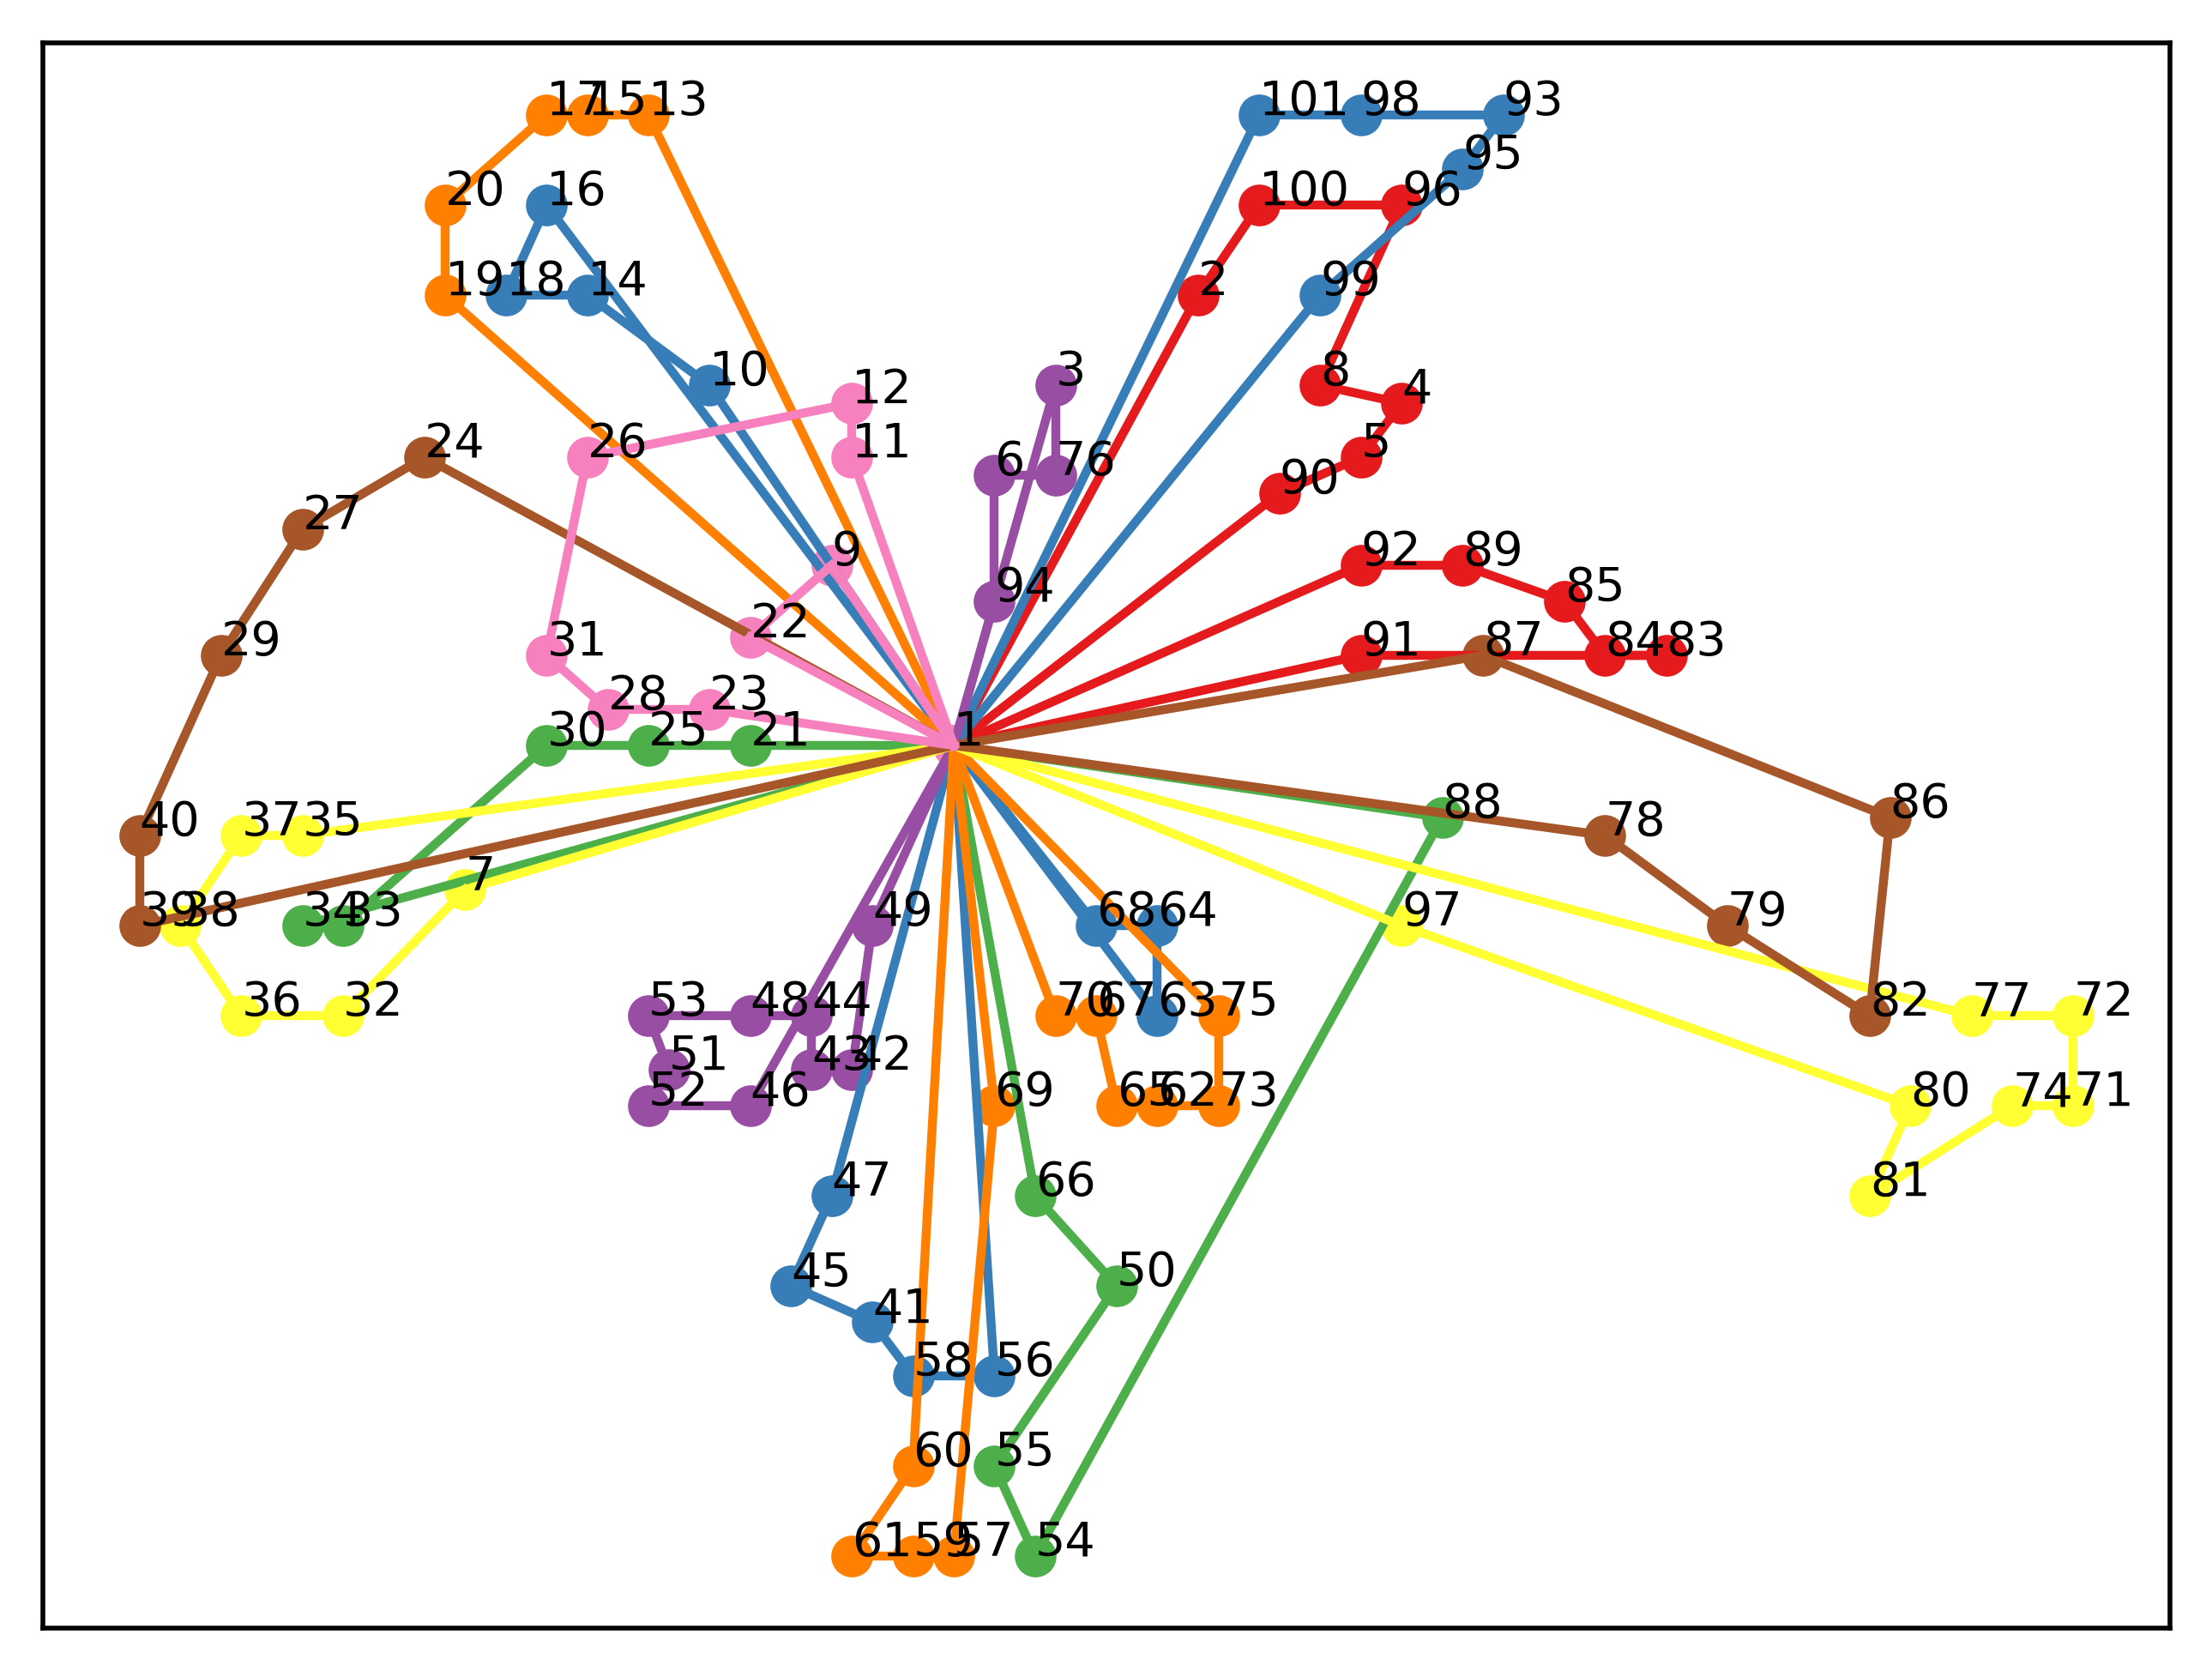

In [ ]:
# Choosing colors
colors = ["red","blue","green",'orange','purple','yellow','black','black']

cmap = mpl.colormaps["Set1"]
colors = cycle(cmap.colors)

fig, ax = plt.subplots(dpi=500)
ax.xaxis.set_visible(False)  # Hide X-axis
ax.yaxis.set_visible(False)  # Hide Y-axis
# ax.set_aspect('equal')

# Now the figure
for i, coord in enumerate(coordinates):
    x = coord[0]
    y= coord[1]
    # ax.scatter(x,y, color = 'grey', s= 10)
    ax.annotate(cust_no[i], (x,y), fontsize = 8)

#print ('Number of nodes:',N)
for k in range(N_VEHICLES):
    # c = colors[k]
    c = next(colors)
    for r in model.R:
        for i in range(len(demands)):
            for j in range(len(demands)):
                if i ==j: 
                    continue
                elif np.isclose(model.X[i, j, k,r].value, 1, atol=1e-1):
                    coord1 = coordinates[i]
                    coord2 = coordinates[j]
                    x1 = coord1[0]
                    y1 = coord1[1]
                    x2 = coord2[0]
                    y2 = coord2[1]
                    if i ==0 :
                        f = 0
                        d = 0
                    else: 
                        demand_shuffled = demands_shuffled[i]
                        f= np.nonzero(demand_shuffled)
                        d = demand_shuffled[f].astype(int)[0]
                        f = f[0][0]

                    ax.scatter(x1,y1, color = c)

                    # ax.annotate((i,d), (x1,y1))
                    ax.plot((x1,x2), (y1,y2), color=c, label= k+1)
#ax.legend()


for k in range(N_VEHICLES):
    print("\nVehicle no:", k+1)
    node = 0
    #print (node, end ='')
    for r in model.R:
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        print (cust_no[node], " --", cust_no[j], end =' ')
                        print ("R:",r)
                        node = j
                        break
            if node == 0:
                break
    #print ("\n")


## Checking loading constraints

In [ ]:
for k in range(N_VEHICLES):
    print('\n',"Vehicle no:", k+1)
    print("Max Capacity of vehicle:", vehicle_capacities[k])
    node = 0
    #print (node, end ='')
    for r in model.R:
        print ('\n', 'Trip:', r)
        #for f in model.F:
        print ('Total loaded onto vehicle', r,':',model.S[k,r].value)
        load = [model.L[0,k,r,f].value for f in model.F]
        print ('Vehicle Load at depot', [model.L[0,k,r,f].value for f in model.F])
        total = np.zeros(DEMAND_TYPES)
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        
                        print ('Cust is:', cust_no[node])
                    
                        print ('Vehicle load', load)
                        print ('Load at node:', demands_shuffled[node])
                        load -= demands_shuffled[node]
                        total += demands_shuffled[node]
                        node = j
                        break
            if node ==0:
                 break
        print ('Remaining Vehicle load', [model.L[N+1,k,r,f].value for f in model.F])
        print('Total delviered:',total)
    '''
    print ('Load at node:', nodes[j])
    print ('Load after visiting node',node,':',model.L[j,k].value)
    print ('\n')
    '''


 Vehicle no: 1
Max Capacity of vehicle: [100 100 100 100 100]

 Trip: 0
Total loaded onto vehicle 0 : 0.0
Vehicle Load at depot [100.0, 100.0, 100.0, 100.0, 100.0]
Remaining Vehicle load [100.0, 100.0, 100.0, 100.0, 100.0]
Total delviered: [0. 0. 0. 0. 0.]

 Trip: 1
Total loaded onto vehicle 1 : 0.0
Vehicle Load at depot [100.0, 100.0, 100.0, 100.0, 100.0]
Remaining Vehicle load [100.0, 100.0, 100.0, 100.0, 100.0]
Total delviered: [0. 0. 0. 0. 0.]

 Trip: 2
Total loaded onto vehicle 2 : 126.0
Vehicle Load at depot [100.0, 100.0, 100.0, 100.0, 100.0]
Cust is: 1
Vehicle load [100.0, 100.0, 100.0, 100.0, 100.0]
Load at node: [0 0 0 0 0]
Cust is: 2
Vehicle load [100. 100. 100. 100. 100.]
Load at node: [10  0  0  0  0]
Cust is: 100
Vehicle load [ 90. 100. 100. 100. 100.]
Load at node: [10  0  0  0  0]
Cust is: 96
Vehicle load [ 80. 100. 100. 100. 100.]
Load at node: [30  0  0  0  0]
Cust is: 8
Vehicle load [ 50. 100. 100. 100. 100.]
Load at node: [20  0  0  0  0]
Cust is: 4
Vehicle load [ 

## Checking time constraints

In [ ]:
for k in range(N_VEHICLES):
    print("Vehicle no:", k+1)
    node = 0
    #print (node, end ='')
    for r in model.R:
        print ('\n', 'Trip no:', r)
        print ('Total load of trip', r,':',model.S[k,r].value)
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        print ('Time window at cust:',cust_no[node],': [', model.a[node], model.b[node], ']')
                        print ('Time reach cust:',cust_no[node],':', model.T[node,k,r].value, '\n')
                        print ('Service time:', model.s[node])
                        print ('Travel time from', cust_no[node],'to', cust_no[j] ,':', model.t[node,j], '\n')
                        node = j
                        break
            if node ==0:
                 break
        print ('Time at end,',r,':', model.T[N+1,k,r].value)

Vehicle no: 1

 Trip no: 0
Total load of trip 0 : 0.0
Time at end, 0 : 0.0

 Trip no: 1
Total load of trip 1 : 0.0
Time at end, 1 : 0.0

 Trip no: 2
Total load of trip 2 : 126.0
Time window at cust: 1 : [ 0 3390 ]
Time reach cust: 1 : 317.3 

Service time: 0
Travel time from 1 to 2 : 27.7 

Time window at cust: 2 : [ 311 471 ]
Time reach cust: 2 : 471.0 

Service time: 90
Travel time from 2 to 100 : 5.8 

Time window at cust: 100 : [ 407 567 ]
Time reach cust: 100 : 567.0 

Service time: 90
Travel time from 100 to 96 : 7.0 

Time window at cust: 96 : [ 881 1041 ]
Time reach cust: 96 : 881.0 

Service time: 90
Travel time from 96 to 8 : 10.7 

Time window at cust: 8 : [ 1073 1233 ]
Time reach cust: 8 : 1073.0 

Service time: 90
Travel time from 8 to 4 : 4.1 

Time window at cust: 4 : [ 1167 1327 ]
Time reach cust: 4 : 1167.1 

Service time: 90
Travel time from 4 to 5 : 3.6 

Time window at cust: 5 : [ 1261 1421 ]
Time reach cust: 5 : 1261.0 

Service time: 90
Travel time from 5 to 90 : 

## Schedules per vessel

"\nfor n in range(len(demands)):\n    if sum(model.Y[n,k,r].value for k in range(N_VEHICLES) for r in range(R)) != 1:\n        start_time_at_node = model.a[n]\n        service_time_at_node = model.b[n] - model.a[n]\n        ax.add_patch(plt.Rectangle((4-0.25, start_time_at_node), 0.5, service_time_at_node, edgecolor='green',                                            linewidth=2,facecolor='none'))\n        ax.text(4-0.125, start_time_at_node, n, color = 'black', fontsize = 8)\n        "

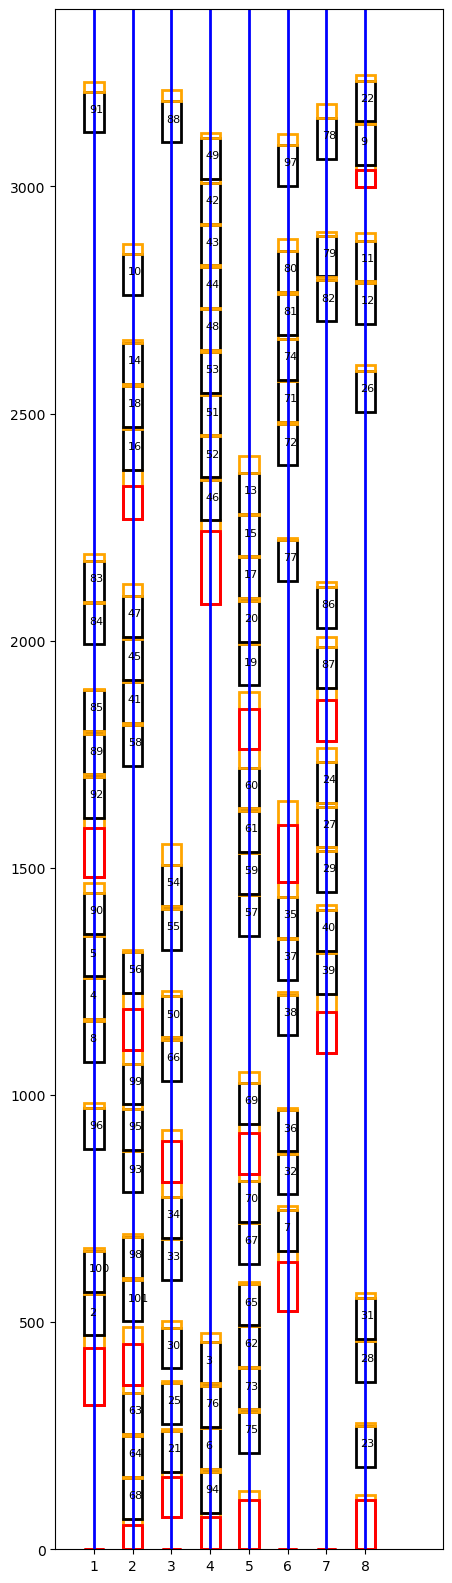

In [ ]:
fig, ax = plt.subplots(figsize = (5,20))
ax.set_xlim(0, N_VEHICLES + 2)
ax.set_ylim(START_TIME, END_TIME)
ax.set_xticks(np.arange(1, N_VEHICLES + 1))
#ax.set_yticks([i for i in range(0,int(yaxislength)+1,43200)])
for k in range(N_VEHICLES):
    ax.plot([k+1, k+1], [START_TIME,END_TIME], linewidth=2, color='b')  #vessel docking period
    for r in range(R): #range(R):
        for i in range(len(demands)):
            for j in range(len(demands)):
                if i ==j: 
                    continue
                elif np.isclose(model.X[i, j, k,r].value, 1, atol=1e-1):
                    
                    time_start_at_node = model.T[i,k,r].value
                    if i !=0: #servicing customers
                        service_time_at_node = model.s[i]
                        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='black',\
                                        linewidth=2,facecolor='none'))
                        ax.text(k+1-0.125, time_start_at_node+(service_time_at_node/2), cust_no[i], color = 'black', fontsize = 8)
                    else: #starting at terminal
                        service_time_at_node = model.S[k,r].value
                        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='red',\
                                        linewidth=2,facecolor='none'))
                    travelling_time = model.t[i,j]
                    ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node+service_time_at_node), 0.5, travelling_time, edgecolor='orange',\
                                        linewidth=2,facecolor='none'))

for k in range(N_VEHICLES):
    for r in range(R):
        time_start_at_node = model.T[0,k,r].value
        service_time_at_node = model.S[k,r].value
        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='red',\
                        linewidth=2,facecolor='none'))